# AI vs. Human-Generated Images Classification - Combined Models

This notebook trains both Vision Transformer (ViT) and ResNet models to classify images as either human-generated (0) or AI-generated (1). It then compares them and then averages the prediction probabilities from both model for soft voting based ensamble learning.

In [1]:
import sys
import os
sys.path.append('../lib')  
import data as dl
import eval as eval_lib
os.chdir('..')
print(f"Working directory: {os.getcwd()}")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
import timm
import torchvision.models as models
import importlib
from sklearn.model_selection import train_test_split
importlib.reload(eval_lib)
importlib.reload(dl)

import warnings
warnings.filterwarnings('ignore')

print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {device_count}")
    
    for i in range(device_count):
        device_properties = torch.cuda.get_device_properties(i)
        print(f"\nGPU {i}: {device_properties.name}")
        print(f"  Memory Total: {device_properties.total_memory / 1e9:.2f} GB")
        
    current_device = torch.cuda.current_device()
    print(f"\nCurrent device: {current_device} ({torch.cuda.get_device_name(current_device)})")
    
    print("\nCurrent memory usage:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

dl.set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Working directory: /home/moh/datascience
CUDA available: True
Number of available GPUs: 1

GPU 0: NVIDIA GeForce RTX 5080
  Memory Total: 17.09 GB

Current device: 0 (NVIDIA GeForce RTX 5080)

Current memory usage:
  Allocated: 0.00 GB
  Cached: 0.00 GB
Random seed set to 42
Using device: cuda


## 1. Data Loading and Exploration

In [ ]:
train_csv = 'train.csv'
full_train_df = pd.read_csv(train_csv)
print(f"Full training data shape: {full_train_df.shape}")

# First split: 70% training+validation, 30% test
train_val_df, test_df = train_test_split(
    full_train_df, 
    test_size=0.3, 
    random_state=42, 
    stratify=full_train_df['label'] if 'label' in full_train_df.columns else None
)

# Second split: From the 70%, take 10% of original data for validation
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1/0.7,
    random_state=42,
    stratify=train_val_df['label'] if 'label' in train_val_df.columns else None
)
# Note: For training: 1,499 × 32 = 47,968 samples (dropping 1 sample)
# For validation: 249 × 32 = 7,968 samples (dropping 28 samples). This isn't an issue as the dataset is large enough.
# But I wanted to let you know we had to drop some samples to get the exact split. You'll see this looking at the dataloaders when droplast=true for training and val.
# Reset indices for all datasets
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print dataset sizes and percentages
print(f"Training data size: {len(train_df)} ({len(train_df)/len(full_train_df)*100:.1f}%)")
print(f"Validation data size: {len(val_df)} ({len(val_df)/len(full_train_df)*100:.1f}%)")
print(f"Test data size: {len(test_df)} ({len(test_df)/len(full_train_df)*100:.1f}%)")

Full training data shape: (79950, 3)
Training data size: 47969 (60.0%)
Validation data size: 7996 (10.0%)
Test data size: 23985 (30.0%)


Dataset shape: (47969, 3)

First few rows:
      id                                        file_name  label
0  27367  train_data/c8c815f4b6d748bbb23a36c192172000.jpg      0
1  70901  train_data/deb2c1635a184395a37c5afb79cf738a.jpg      0
2  46116  train_data/0af72884ad034a728f7f16f634f65e72.jpg      1
3  16194  train_data/f79480e293f54c47aa162020e12aa30e.jpg      1
4  33460  train_data/58b4b509eb3a437c96b7b5f96a23bc4c.jpg      1

Columns:
['id', 'file_name', 'label']

Missing values:
No missing values

Label distribution:
  AI-generated: 23985 (50.0%)
  Human-generated: 23984 (50.0%)


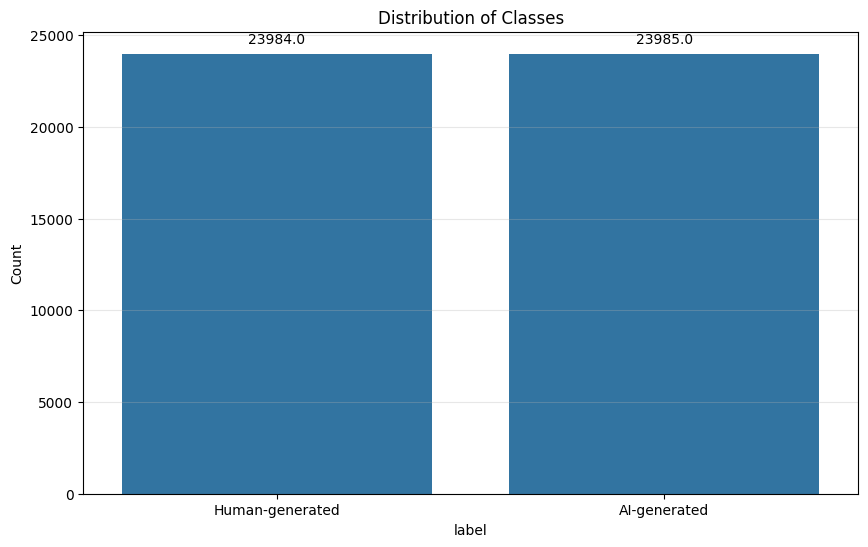

In [3]:
label_names = {0: 'Human-generated', 1: 'AI-generated'}
dl.explore_dataset(train_df, label_col='label', label_names=label_names)

In [4]:
dl.check_data_integrity(train_df, image_col='file_name', sample_size=10)

Checking 10 random images for integrity...
train_data/9fd3354982d8423ca8694c709e4bc898.jpg - Valid
train_data/361ffdbc4bd743d8872be3965c61fd35.jpg - Valid
train_data/31421efcab084bbbb1821fb49fe8bdf3.jpg - Valid
train_data/b19d7a7678d34b2fa5af18e82a01a6f8.jpg - Valid
train_data/0b85e64101584bfe9a417996b83d6cf3.jpg - Valid
train_data/fcb359291c1240f785aa86a141dd4a65.jpg - Valid
train_data/bc9bf58d3bf543ff9e2d03112c345e4b.jpg - Valid
train_data/b5bb3525ca154e9b8c76a0bd85f11f5a.jpg - Valid
train_data/9e899b061a9c40c38624076683a329fe.jpg - Valid
train_data/5c327b0f203040938a3d143c0dc391de.jpg - Valid
All sampled images are valid.


True

Examples of class 0 and class 1 side by side

Examples of Human-Generated Images (Class 0):


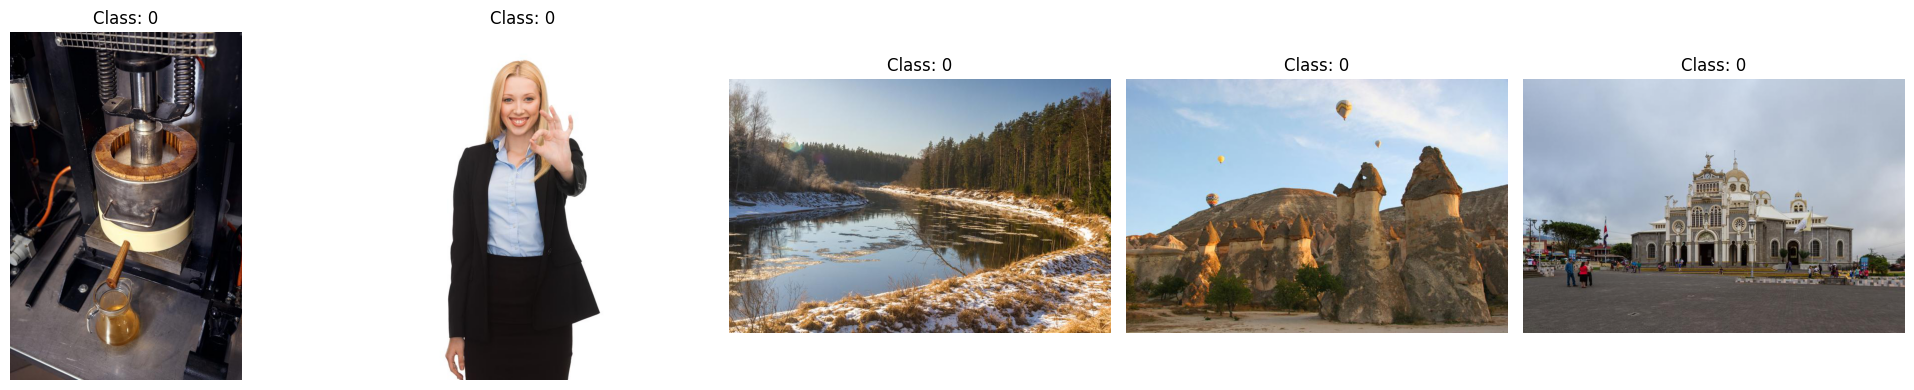

Examples of AI-Generated Images (Class 1):


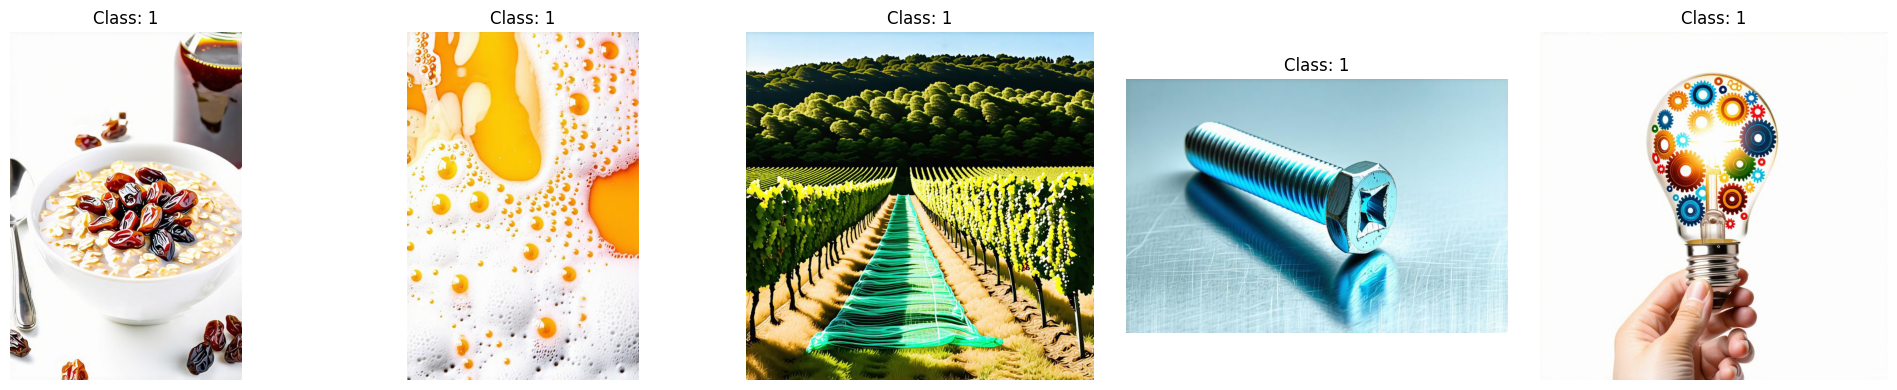

In [5]:
print("Examples of Human-Generated Images (Class 0):")
dl.display_images_by_class(train_df, 0, label_col='label', image_col='file_name', num_images=5)

print("Examples of AI-Generated Images (Class 1):")
dl.display_images_by_class(train_df, 1, label_col='label', image_col='file_name', num_images=5)

Display image statistics to look for systematic differences between classes.

Human-generated image statistics:
Analyzing dimensions for 50 random images...

Image dimension statistics:
Width: min=496, max=768, mean=701.8
Height: min=352, max=768, mean=588.2
Aspect ratio: min=0.65, max=2.18, mean=1.28


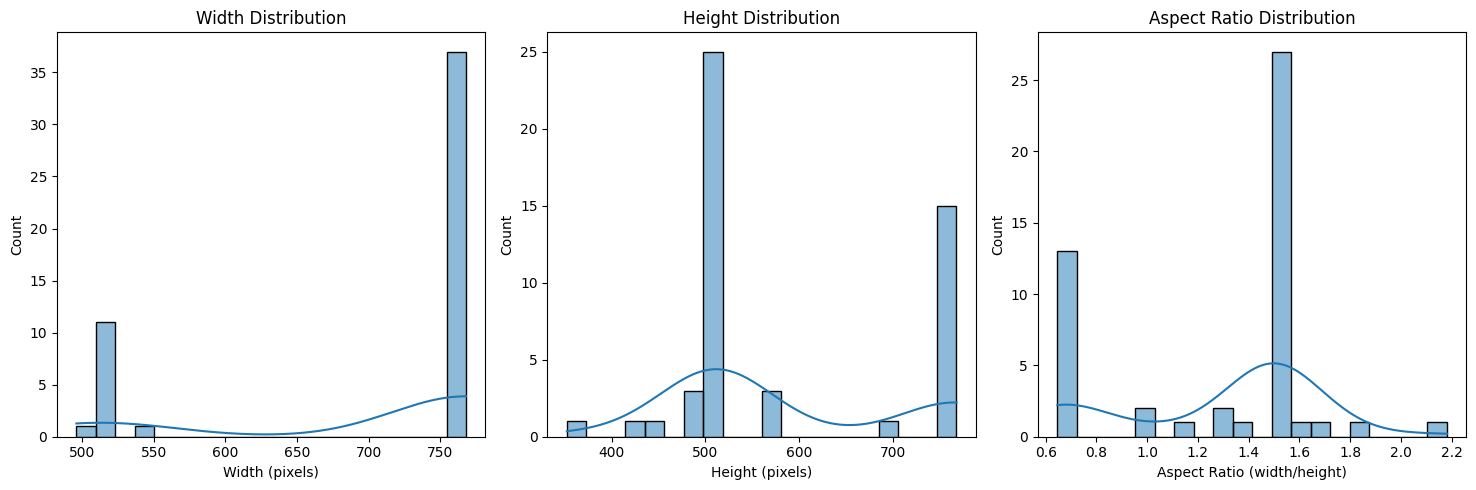

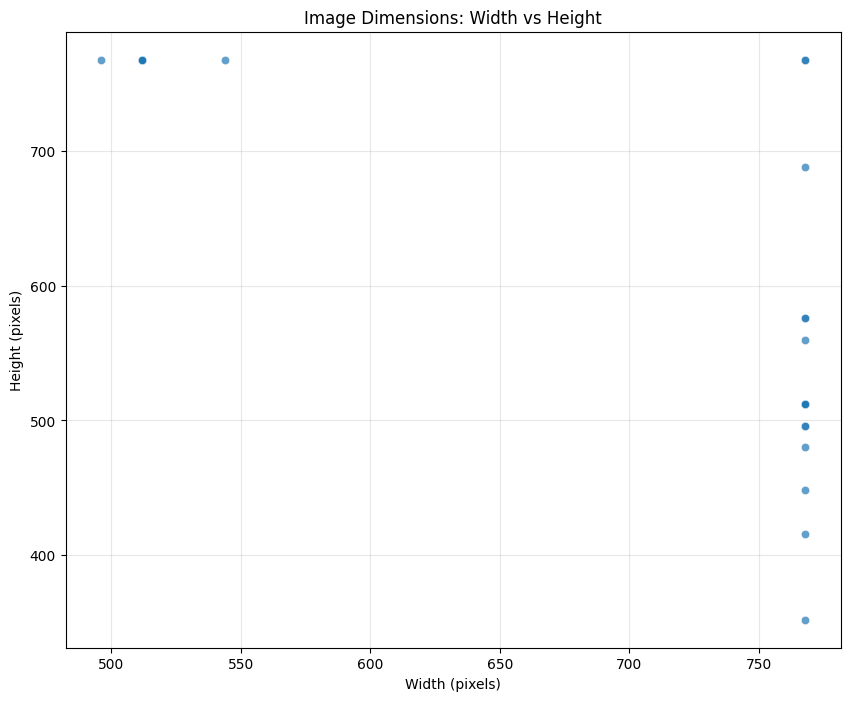


AI-generated image statistics:
Analyzing dimensions for 50 random images...

Image dimension statistics:
Width: min=496, max=768, mean=740.2
Height: min=448, max=768, mean=572.8
Aspect ratio: min=0.65, max=1.71, mean=1.35


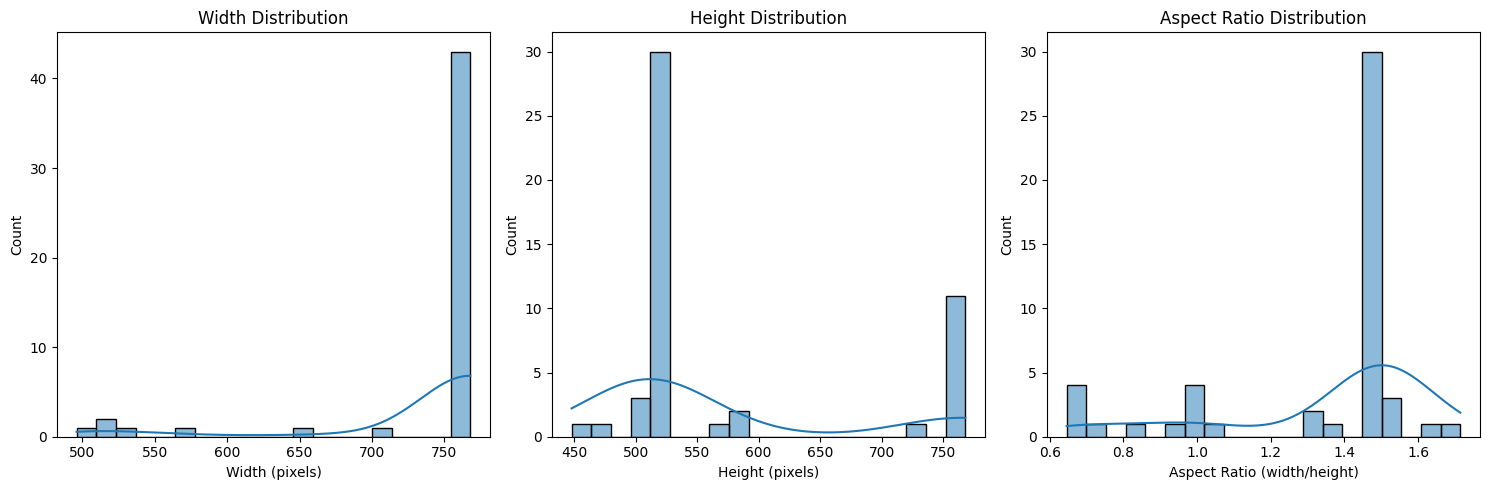

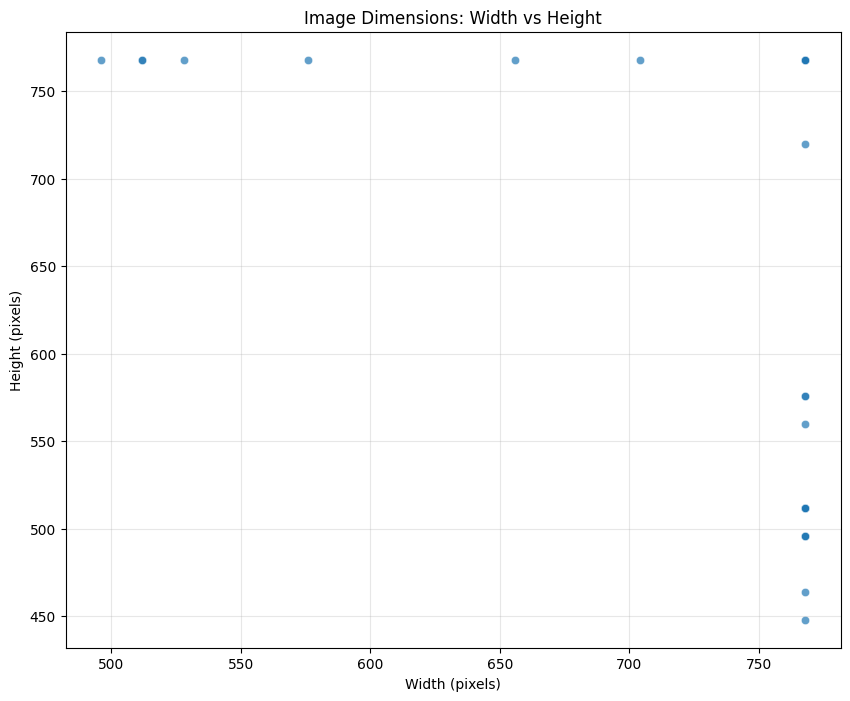

In [6]:
human_df = train_df[train_df['label'] == 0]
ai_df = train_df[train_df['label'] == 1]

print("Human-generated image statistics:")
human_stats = dl.get_image_statistics(human_df, sample_size=50)

print("\nAI-generated image statistics:")
ai_stats = dl.get_image_statistics(ai_df, sample_size=50)

## 2. Creating DataLoaders with data augmentation using transforms.
Data loaders efficiently feed our training and test data to the models in batches, while applying image augmentations to help improve generalization.

In [7]:
batch_size = 32
image_size = 224
num_workers = 8

train_loader, test_loader, val_loader = dl.create_dataloaders(
    train_df,
    test_df,
    val_df,
    batch_size=batch_size,
    image_size=image_size,
    num_workers=num_workers
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 1499
Number of test batches: 749


Visualize Augmented Samples

Training images with augmentation applied:


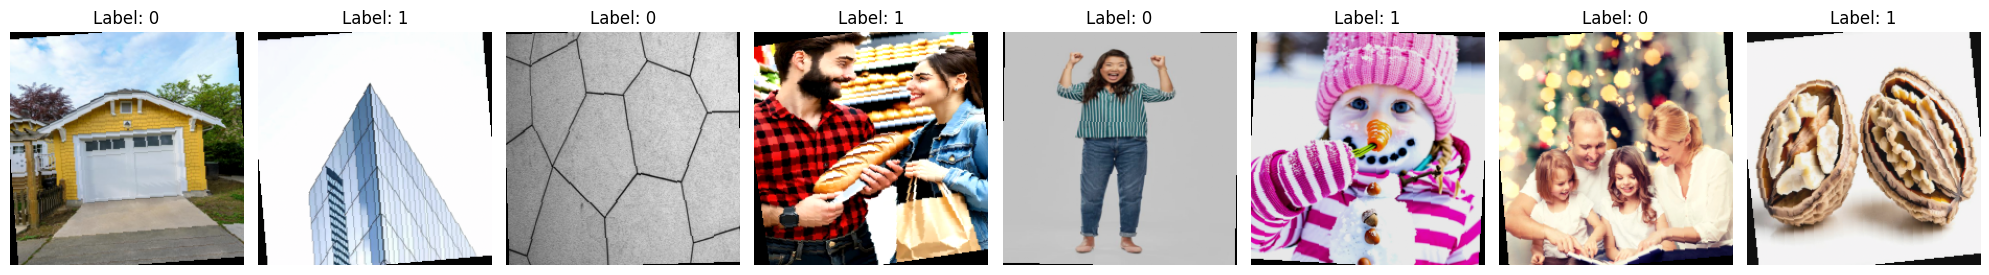

In [8]:
print("Training images with augmentation applied:")
dl.show_augmented_samples(train_loader, num_images=8)

## 3. Model Definition - ViT and ResNet

Now we'll set up both Vision Transformer and ResNet models with appropriate regularization.

In [9]:
def create_vit_model(pretrained=True, dropout_rate=0.2):
    model = timm.create_model('vit_base_patch16_224', pretrained=pretrained, drop_rate=dropout_rate)
    
    # Modify the classifier head for binary classification
    num_features = model.head.in_features
    model.head = nn.Linear(num_features, 1)
    
    return model

def create_resnet_model(pretrained=True, dropout_rate=0.2):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.BatchNorm1d(num_features),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(dropout_rate),
        nn.Linear(512, 1)
    )
    
    return model
vit_model = create_vit_model(pretrained=True, dropout_rate=0.2)
vit_model = vit_model.to(device)
vit_params = sum(p.numel() for p in vit_model.parameters())
print(f"ViT model parameters: {vit_params:,}")

resnet_model = create_resnet_model(pretrained=True, dropout_rate=0.2)
resnet_model = resnet_model.to(device)
resnet_params = sum(p.numel() for p in resnet_model.parameters())
print(f"ResNet model parameters: {resnet_params:,}")

ViT model parameters: 85,799,425
ResNet model parameters: 24,562,753


## 4. Training Functions

Now, let's define the universal training functions we'll use for both models.

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, scaler, step_scheduler_per_batch=False):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    
    total_batches = len(dataloader)
    print(f"Total batches: {total_batches}")
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device, non_blocking=True)
        labels = labels.float().to(device, non_blocking=True).unsqueeze(1)
        
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Step the scheduler after each batch
        if step_scheduler_per_batch and scheduler is not None and not isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step()
        
        total_loss += loss.item() * images.size(0)
        
        with torch.no_grad():
            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
        
        all_predictions.extend(preds.flatten().tolist())
        all_labels.extend(labels.cpu().numpy().flatten().tolist())
        all_probs.extend(probs.flatten().tolist())
        
        # Print progress at regular intervals
        if batch_idx % max(1, total_batches // 20) == 0 or batch_idx == total_batches - 1:
            progress = batch_idx / total_batches * 100
            print(f"  Batch {batch_idx+1}/{total_batches} ({progress:.1f}%) - Loss: {loss.item():.4f}")

    metrics = eval_lib.compute_metrics(all_labels, all_predictions, all_probs)
    metrics['loss'] = total_loss / len(dataloader.dataset)
    
    return metrics

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=5, model_name="model"):
    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_weights = None
    no_improve_count = 0
    
    for epoch in range(num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{num_epochs} - {model_name}")
        print(f"{'='*50}")
        
        print("Starting training phase...")
        train_metrics = train_epoch(
            model, train_loader, criterion, optimizer, scheduler, device, scaler,
            step_scheduler_per_batch=False
        )
        
        print("Starting validation phase...")
        val_metrics = eval_lib.validate(model, val_loader, criterion, device) 
        
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_metrics['loss']) 
            else:
                scheduler.step()
        
        print(f"Training    - Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1']:.4f}")
        print(f"Validation  - Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}")
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_model_weights = model.state_dict().copy()
            print(f"New best model saved with validation F1: {best_val_f1:.4f}") 
            no_improve_count = 0 
        else:
            no_improve_count += 1
            print(f"No improvement for {no_improve_count} epochs")
            
        if no_improve_count >= patience:
            print(f"Early stopping after {epoch+1} epochs without improvement")
            break

        history['train_loss'].append(train_metrics['loss'])
        history['train_acc'].append(train_metrics['accuracy'])
        history['train_f1'].append(train_metrics['f1'])
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
    
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"Loaded best model with validation F1: {best_val_f1:.4f}")
    
    return model, history

## 5. Training ViT Model

Let's train the Vision Transformer model with appropriate hyperparameters.

In [12]:
# Loss function: BCEWithLogitsLoss
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html


# For understanding weight decay selection, see:
# https://medium.com/@noorfatimaafzalbutt/understanding-weight-decay-why-it-matters-in-training-large-language-models-b3a5f1ee2e9a
# https://yassin01.medium.com/adam-vs-adamw-understanding-weight-decay-and-its-impact-on-model-performance-b7414f0af8a1

# Learning rate scheduler: ReduceLROnPlateau reduces learning rate when metrics plateau
#https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
vit_criterion = nn.BCEWithLogitsLoss()
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=1e-2)
vit_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    vit_optimizer, mode='min', factor=0.5, patience=2
)

vit_epochs = 20
vit_patience = 3 

vit_model, vit_history = train_model(
    vit_model, 
    train_loader,
    val_loader, 
    vit_criterion, 
    vit_optimizer,
    vit_scheduler,
    num_epochs=vit_epochs,
    patience=vit_patience,
    model_name="ViT"
)

torch.save(vit_model.state_dict(), 'ai_vs_human_vit_model.pth')


Epoch 1/20 - ViT
Starting training phase...
Total batches: 1499
  Batch 1/1499 (0.0%) - Loss: 0.9769
  Batch 75/1499 (4.9%) - Loss: 0.2499
  Batch 149/1499 (9.9%) - Loss: 0.1396
  Batch 223/1499 (14.8%) - Loss: 0.1944
  Batch 297/1499 (19.7%) - Loss: 0.1663
  Batch 371/1499 (24.7%) - Loss: 0.4508
  Batch 445/1499 (29.6%) - Loss: 0.1850
  Batch 519/1499 (34.6%) - Loss: 0.0407
  Batch 593/1499 (39.5%) - Loss: 0.0849
  Batch 667/1499 (44.4%) - Loss: 0.0822
  Batch 741/1499 (49.4%) - Loss: 0.2011
  Batch 815/1499 (54.3%) - Loss: 0.1450
  Batch 889/1499 (59.2%) - Loss: 0.2707
  Batch 963/1499 (64.2%) - Loss: 0.0883
  Batch 1037/1499 (69.1%) - Loss: 0.2839
  Batch 1111/1499 (74.0%) - Loss: 0.1367
  Batch 1185/1499 (79.0%) - Loss: 0.0801
  Batch 1259/1499 (83.9%) - Loss: 0.1309
  Batch 1333/1499 (88.9%) - Loss: 0.1012
  Batch 1407/1499 (93.8%) - Loss: 0.1604
  Batch 1481/1499 (98.7%) - Loss: 0.0700
  Batch 1499/1499 (99.9%) - Loss: 0.1362
Starting validation phase...
Training    - Loss: 0.16

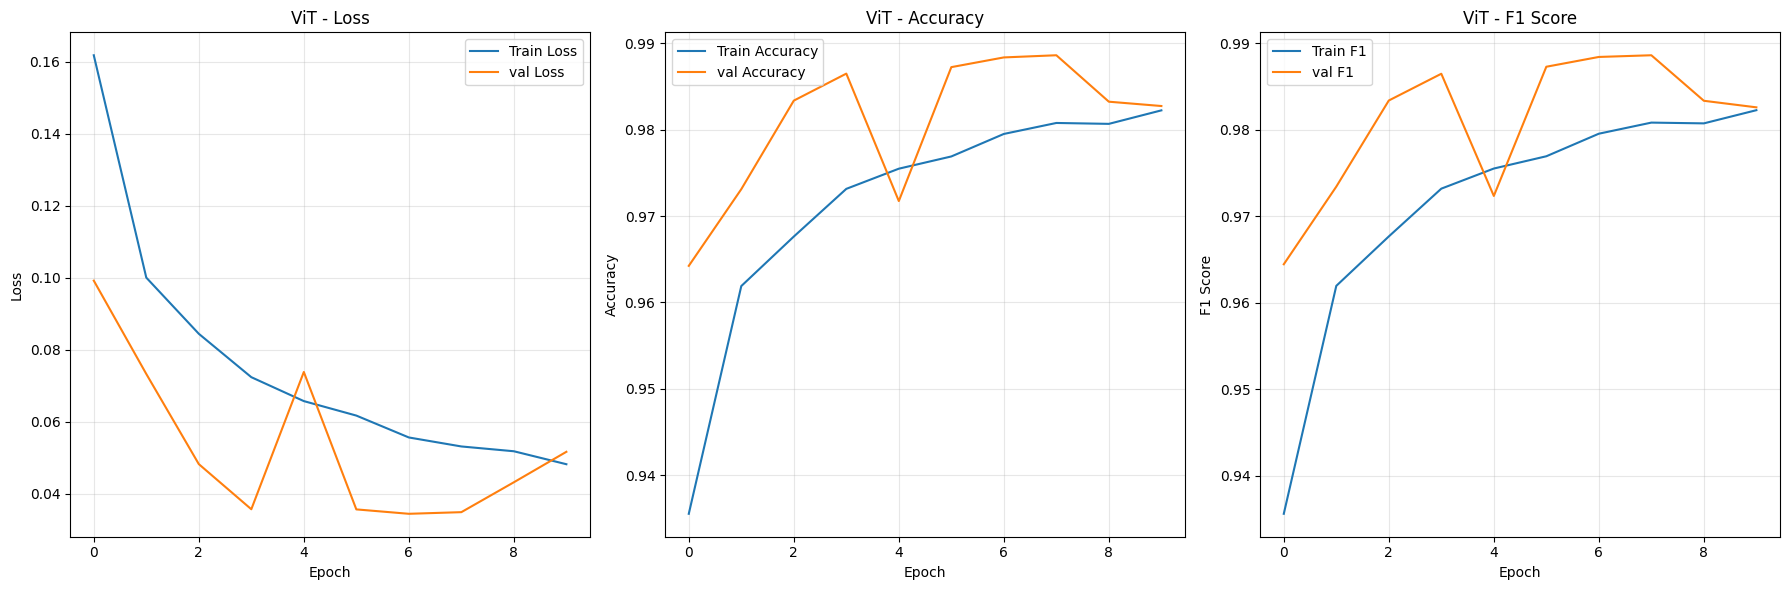

In [13]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(vit_history['train_loss'], label='Train Loss')
plt.plot(vit_history['val_loss'], label='val Loss')
plt.title('ViT - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(vit_history['train_acc'], label='Train Accuracy')
plt.plot(vit_history['val_acc'], label='val Accuracy')
plt.title('ViT - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(vit_history['train_f1'], label='Train F1')
plt.plot(vit_history['val_f1'], label='val F1')
plt.title('ViT - F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('vit_training_history.png', dpi=300)
plt.show()

## 6. Training ResNet Model

Now let's train the ResNet model using CNN-appropriate hyperparameters.

In [14]:
# Loss function: BCEWithLogitsLoss
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

# For understanding weight decay selection, see:
# https://medium.com/@noorfatimaafzalbutt/understanding-weight-decay-why-it-matters-in-training-large-language-models-b3a5f1ee2e9a
# https://yassin01.medium.com/adam-vs-adamw-understanding-weight-decay-and-its-impact-on-model-performance-b7414f0af8a1

# Learning rate scheduler: ReduceLROnPlateau reduces learning rate when metrics plateau
#https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
resnet_criterion = nn.BCEWithLogitsLoss()
resnet_optimizer = optim.AdamW(resnet_model.parameters(), lr=1e-4, weight_decay=5e-4) 
resnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    resnet_optimizer, mode='min', factor=0.5, patience=2
)

resnet_epochs = 20 
resnet_patience = 3
 
resnet_model, resnet_history = train_model(
    resnet_model, 
    train_loader,
    val_loader, 
    resnet_criterion, 
    resnet_optimizer,
    resnet_scheduler,
    num_epochs=resnet_epochs,
    patience=resnet_patience,
    model_name="ResNet"
)

torch.save(resnet_model.state_dict(), 'ai_vs_human_resnet_model.pth')


Epoch 1/20 - ResNet
Starting training phase...
Total batches: 1499
  Batch 1/1499 (0.0%) - Loss: 0.7423
  Batch 75/1499 (4.9%) - Loss: 0.1310
  Batch 149/1499 (9.9%) - Loss: 0.1286
  Batch 223/1499 (14.8%) - Loss: 0.4250
  Batch 297/1499 (19.7%) - Loss: 0.0324
  Batch 371/1499 (24.7%) - Loss: 0.1511
  Batch 445/1499 (29.6%) - Loss: 0.2283
  Batch 519/1499 (34.6%) - Loss: 0.2693
  Batch 593/1499 (39.5%) - Loss: 0.1406
  Batch 667/1499 (44.4%) - Loss: 0.1136
  Batch 741/1499 (49.4%) - Loss: 0.2015
  Batch 815/1499 (54.3%) - Loss: 0.0686
  Batch 889/1499 (59.2%) - Loss: 0.1400
  Batch 963/1499 (64.2%) - Loss: 0.0122
  Batch 1037/1499 (69.1%) - Loss: 0.1856
  Batch 1111/1499 (74.0%) - Loss: 0.0697
  Batch 1185/1499 (79.0%) - Loss: 0.0322
  Batch 1259/1499 (83.9%) - Loss: 0.0722
  Batch 1333/1499 (88.9%) - Loss: 0.0511
  Batch 1407/1499 (93.8%) - Loss: 0.0325
  Batch 1481/1499 (98.7%) - Loss: 0.0675
  Batch 1499/1499 (99.9%) - Loss: 0.0132
Starting validation phase...
Training    - Loss: 0

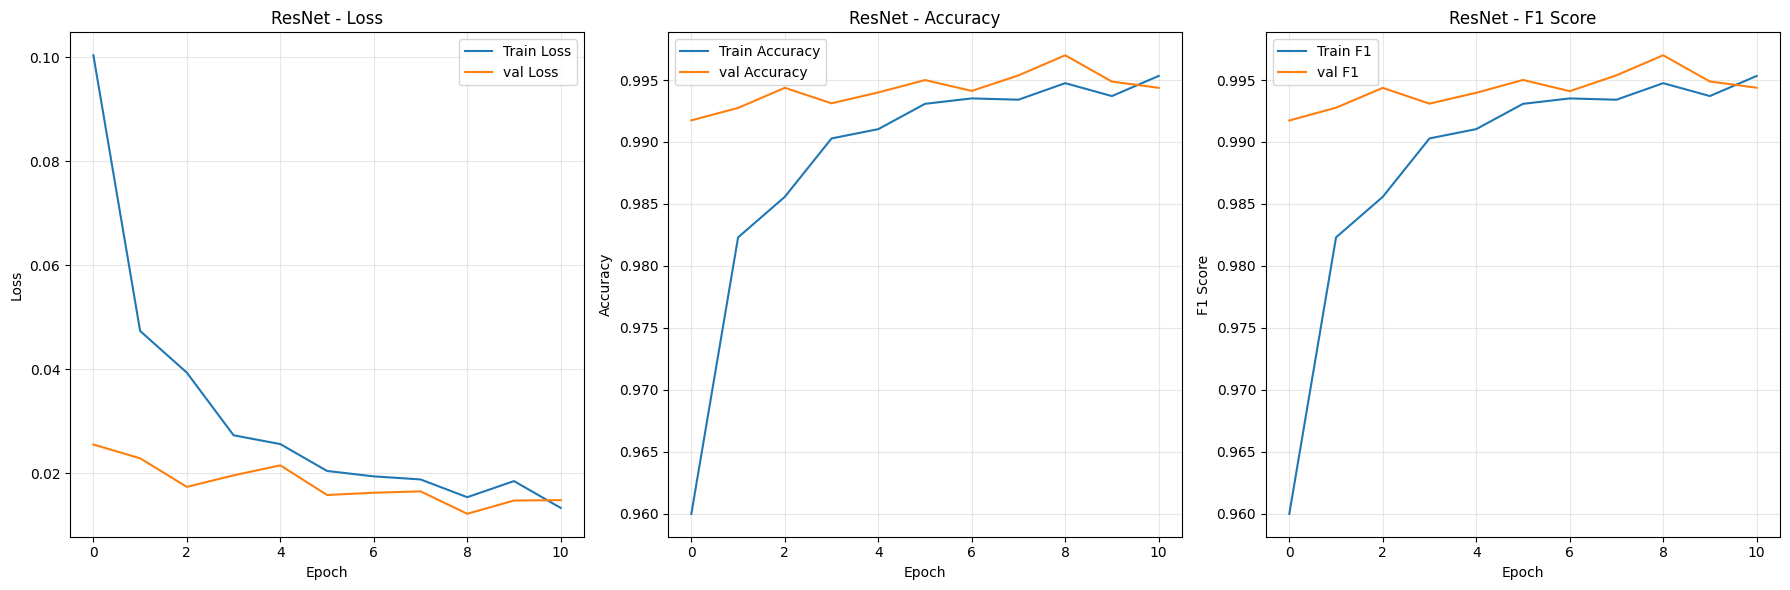

In [15]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(resnet_history['train_loss'], label='Train Loss')
plt.plot(resnet_history['val_loss'], label='val Loss')
plt.title('ResNet - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(resnet_history['train_acc'], label='Train Accuracy')
plt.plot(resnet_history['val_acc'], label='val Accuracy')
plt.title('ResNet - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(resnet_history['train_f1'], label='Train F1')
plt.plot(resnet_history['val_f1'], label='val F1')
plt.title('ResNet - F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('resnet_training_history.png', dpi=300)
plt.show()

## 7. Model Evaluation and Comparison

Now let's evaluate both models on the test set and compare their performance.


Evaluating ViT model on test set...

Evaluating on test set...

===== Test Set Results =====
Loss: 0.0413
RMSE: 0.1040
AUC: 0.9990
Average Precision: 0.9990

Classification Report:
              precision    recall  f1-score   support

       Human       0.99      0.98      0.99     11986
AI-generated       0.98      0.99      0.99     11982

    accuracy                           0.99     23968
   macro avg       0.99      0.99      0.99     23968
weighted avg       0.99      0.99      0.99     23968

Saved test metrics to evaluation_results/vit/test_metrics.csv
Saved test predictions to evaluation_results/vit/test_predictions.csv
Saved confusion matrix to evaluation_results/vit/test_confusion_matrix.png


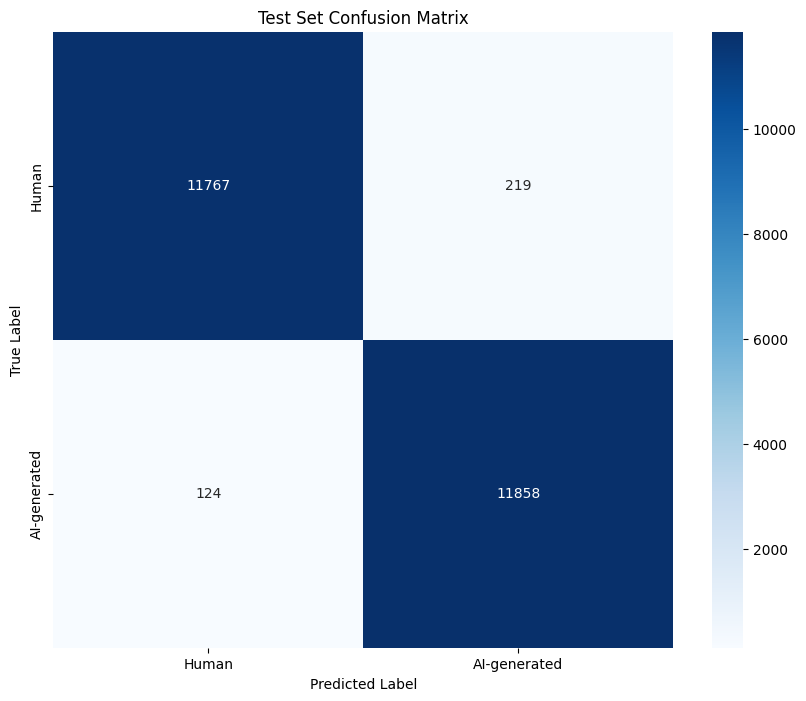

Saved curves to evaluation_results/vit/test_curves.png


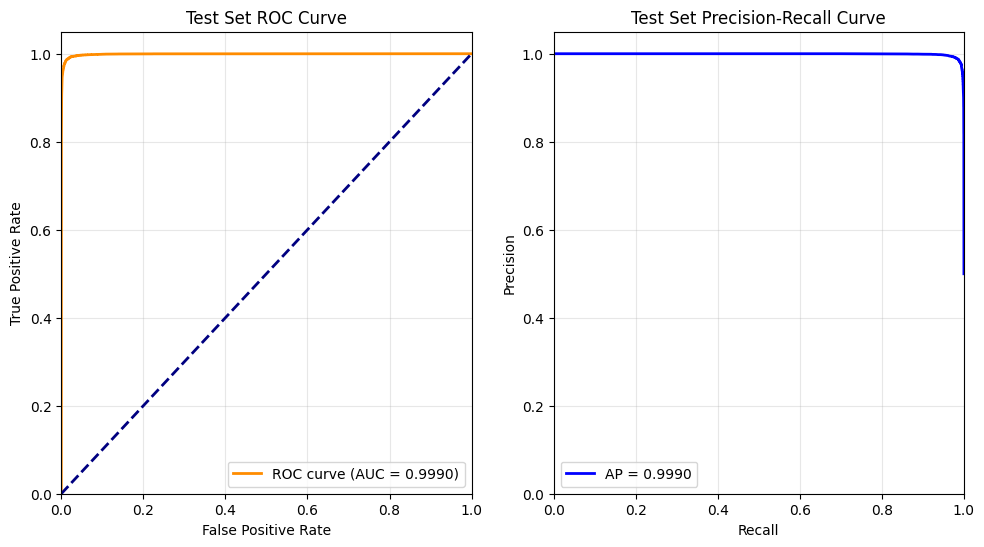


Evaluating ResNet model on test set...

Evaluating on test set...

===== Test Set Results =====
Loss: 0.0184
RMSE: 0.0693
AUC: 0.9997
Average Precision: 0.9997

Classification Report:
              precision    recall  f1-score   support

       Human       0.99      0.99      0.99     11986
AI-generated       0.99      0.99      0.99     11982

    accuracy                           0.99     23968
   macro avg       0.99      0.99      0.99     23968
weighted avg       0.99      0.99      0.99     23968

Saved test metrics to evaluation_results/resnet/test_metrics.csv
Saved test predictions to evaluation_results/resnet/test_predictions.csv
Saved confusion matrix to evaluation_results/resnet/test_confusion_matrix.png


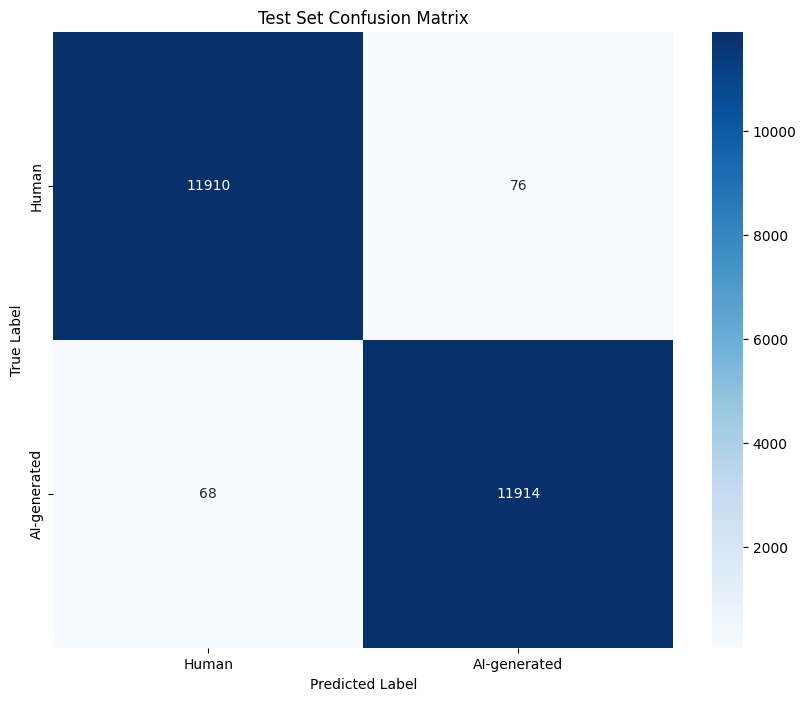

Saved curves to evaluation_results/resnet/test_curves.png


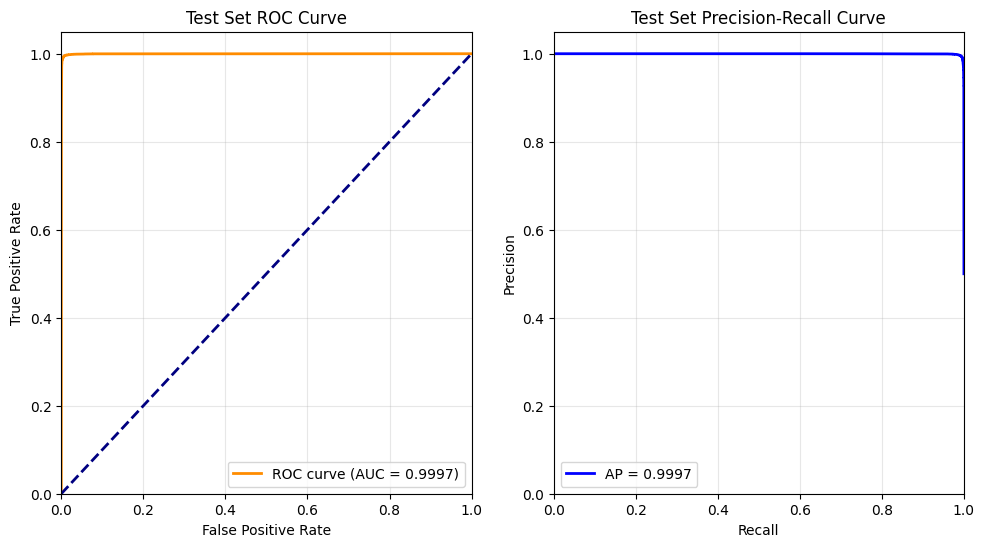

In [16]:
from importlib import reload
results_dir = 'evaluation_results'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(os.path.join(results_dir, 'vit'), exist_ok=True)
os.makedirs(os.path.join(results_dir, 'resnet'), exist_ok=True)

print("\nEvaluating ViT model on test set...")
reload(eval_lib)
vit_metrics = eval_lib.evaluate_test_set(
    vit_model, test_loader, vit_criterion, device, save_path=os.path.join(results_dir, 'vit')
)

print("\nEvaluating ResNet model on test set...")
reload(eval_lib)
resnet_metrics = eval_lib.evaluate_test_set(
    resnet_model, test_loader, resnet_criterion, device, save_path=os.path.join(results_dir, 'resnet')
)


Misclassified examples from ViT model:


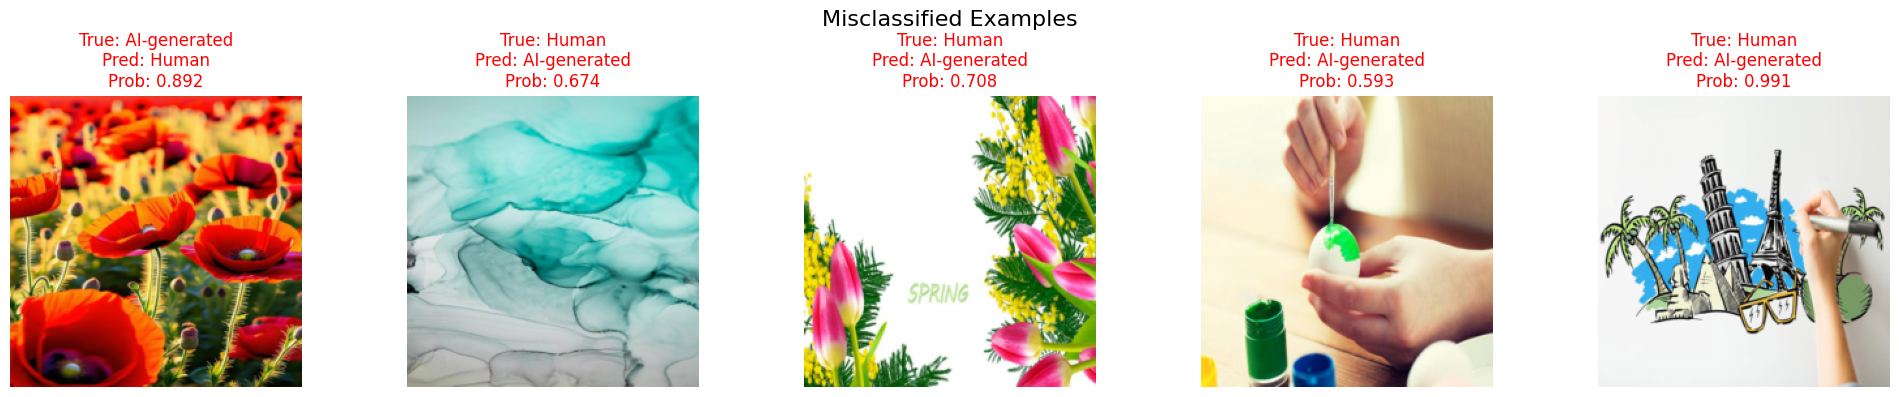


Misclassified examples from ResNet model:


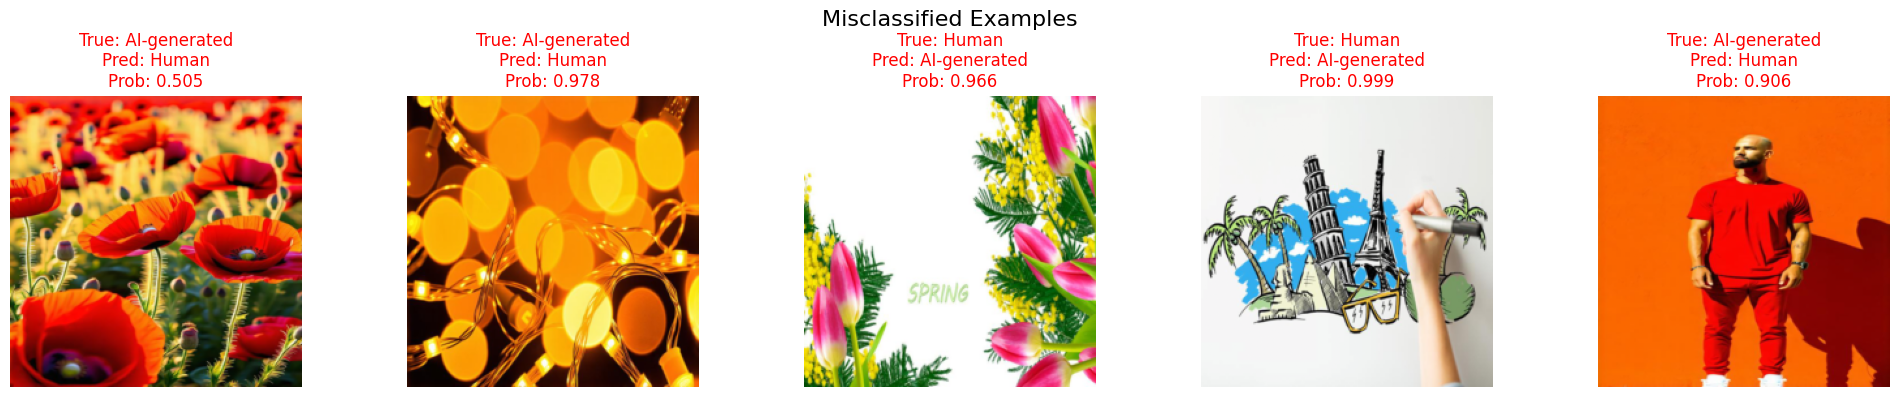

In [17]:
print("\nMisclassified examples from ViT model:")
eval_lib.show_misclassified_examples(vit_model, test_loader, num_examples=5, device=device)

print("\nMisclassified examples from ResNet model:")
eval_lib.show_misclassified_examples(resnet_model, test_loader, num_examples=5, device=device)

## 8. Model Performance Comparison

Let's directly compare the performance of both models.

In [18]:
metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'avg_precision', 'rmse']
comparison_data = {
    'Metric': metrics_to_compare,
    'ViT': [vit_metrics[metric] for metric in metrics_to_compare],
    'ResNet': [resnet_metrics[metric] for metric in metrics_to_compare],
    'Difference': [vit_metrics[metric] - resnet_metrics[metric] for metric in metrics_to_compare]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

vit_wins = sum(1 for diff in comparison_data['Difference'] if diff > 0)
resnet_wins = sum(1 for diff in comparison_data['Difference'] if diff < 0)
ties = sum(1 for diff in comparison_data['Difference'] if diff == 0)

print(f"\nMetric Wins: ViT: {vit_wins}, ResNet: {resnet_wins}, Ties: {ties}")

comparison_df.to_csv(os.path.join(results_dir, 'model_comparison.csv'), index=False)


Model Performance Comparison:
       Metric    ViT  ResNet  Difference
     accuracy 0.9857  0.9940     -0.0083
    precision 0.9819  0.9937     -0.0118
       recall 0.9897  0.9943     -0.0047
           f1 0.9857  0.9940     -0.0082
          auc 0.9990  0.9997     -0.0007
avg_precision 0.9990  0.9997     -0.0007
         rmse 0.1040  0.0693      0.0347

Metric Wins: ViT: 1, ResNet: 6, Ties: 0


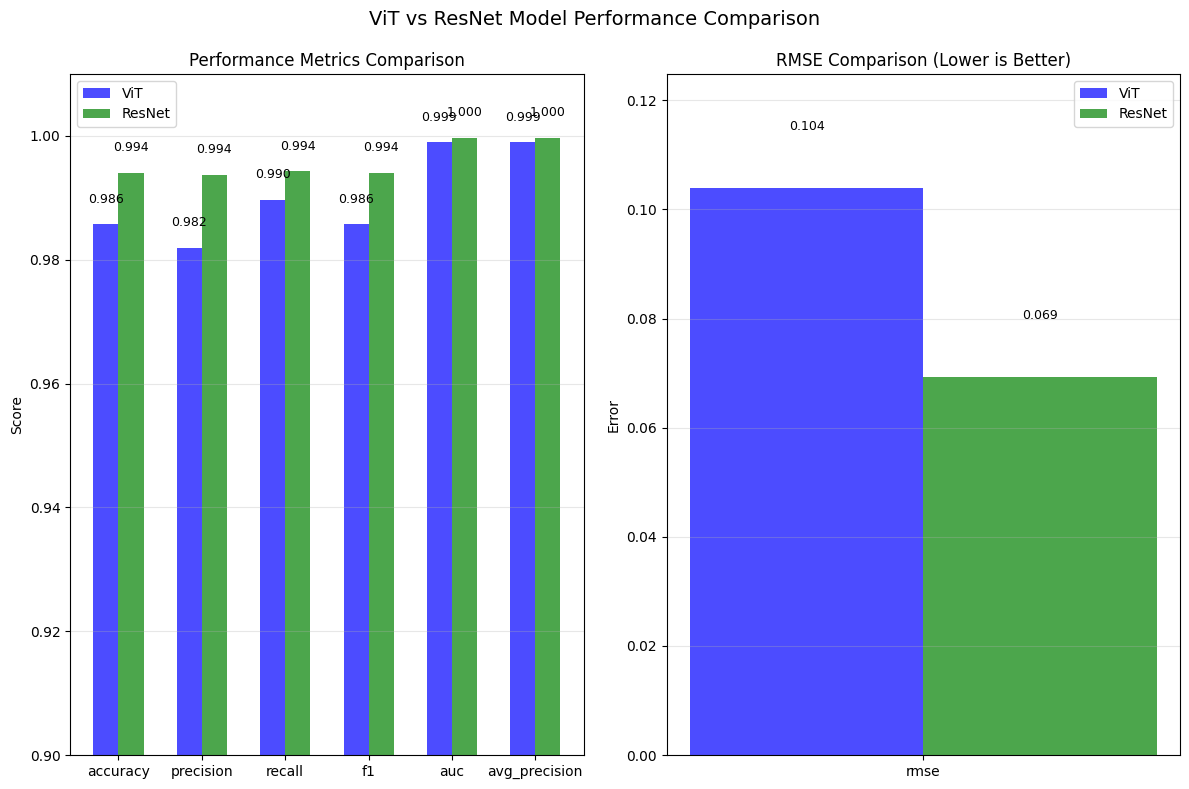

In [19]:
plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_to_compare))
width = 0.3

main_metrics = [m for m in metrics_to_compare if m != 'rmse']
main_x = np.arange(len(main_metrics))

plt.subplot(1, 2, 1)
plt.bar(main_x - width/2, [comparison_df['ViT'][metrics_to_compare.index(m)] for m in main_metrics], 
        width, label='ViT', color='blue', alpha=0.7)
plt.bar(main_x + width/2, [comparison_df['ResNet'][metrics_to_compare.index(m)] for m in main_metrics], 
        width, label='ResNet', color='green', alpha=0.7)

plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(main_x, main_metrics, rotation=0)
plt.ylim(0.9, 1.01)
plt.legend()
plt.grid(axis='y', alpha=0.3)

for i, metric in enumerate(main_metrics):
    idx = metrics_to_compare.index(metric)
    vit_value = comparison_df['ViT'][idx]
    resnet_value = comparison_df['ResNet'][idx]
    
    plt.text(i - width/2, vit_value + 0.003, f"{vit_value:.3f}", 
             ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, resnet_value + 0.003, f"{resnet_value:.3f}", 
             ha='center', va='bottom', fontsize=9)

# Create second subplot for RMSE since its as a different scale
plt.subplot(1, 2, 2)
rmse_idx = metrics_to_compare.index('rmse')
vit_rmse = comparison_df['ViT'][rmse_idx]
resnet_rmse = comparison_df['ResNet'][rmse_idx]

plt.bar([0 - width/2], [vit_rmse], width, label='ViT', color='blue', alpha=0.7)
plt.bar([0 + width/2], [resnet_rmse], width, label='ResNet', color='green', alpha=0.7)

plt.ylabel('Error')
plt.title('RMSE Comparison (Lower is Better)')
plt.xticks([0], ['rmse'])
plt.ylim(0, max(vit_rmse, resnet_rmse) * 1.2)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.text(0 - width/2, vit_rmse + 0.01, f"{vit_rmse:.3f}", ha='center', va='bottom', fontsize=9)
plt.text(0 + width/2, resnet_rmse + 0.01, f"{resnet_rmse:.3f}", ha='center', va='bottom', fontsize=9)

plt.suptitle('ViT vs ResNet Model Performance Comparison', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(os.path.join(results_dir, 'model_comparison.png'), dpi=300)
plt.show()

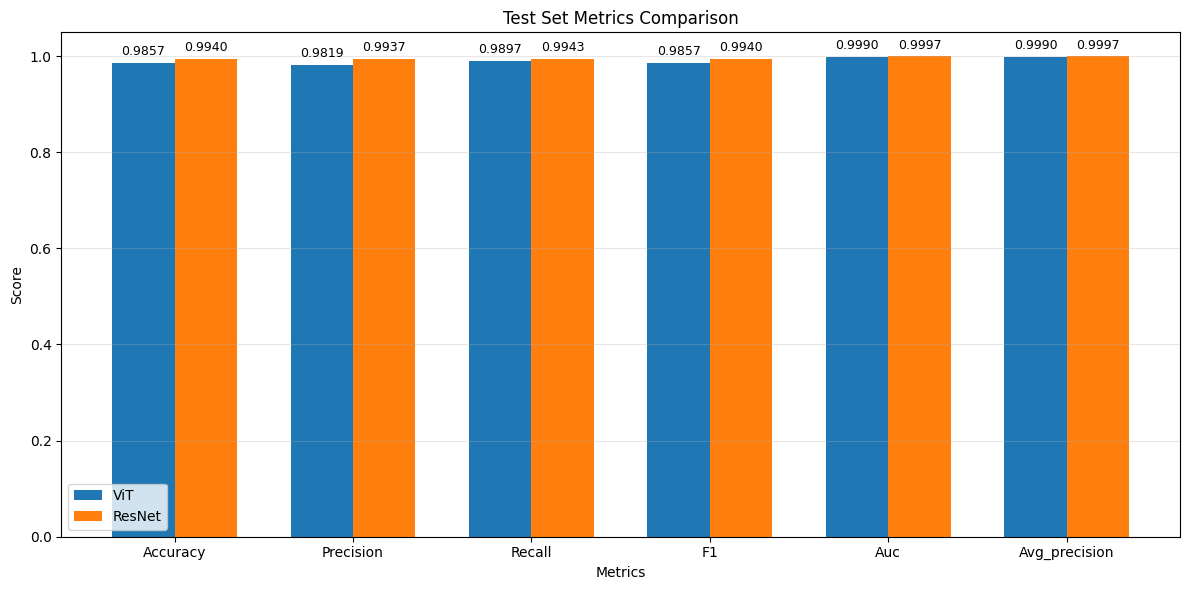

In [ ]:
metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'avg_precision']
x = np.arange(len(metrics_to_compare))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, [vit_metrics[m] for m in metrics_to_compare], width, label='ViT')
plt.bar(x + width/2, [resnet_metrics[m] for m in metrics_to_compare], width, label='ResNet')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Test Set Metrics Comparison')
plt.xticks(x, [m.capitalize() for m in metrics_to_compare])
plt.legend()
plt.grid(alpha=0.3, axis='y')

for i, m in enumerate(metrics_to_compare):
    plt.text(i - width/2, vit_metrics[m] + 0.01, f"{vit_metrics[m]:.4f}", 
             ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, resnet_metrics[m] + 0.01, f"{resnet_metrics[m]:.4f}", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'test_metrics_comparison.png'), dpi=300)
plt.show()

## 9. Analysis of Commonly Misclassified Examples

Let's see which examples are misclassified by both models vs. just one model.

In [23]:
def get_model_predictions(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    all_filenames = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            if isinstance(labels, torch.Tensor):
                images = images.to(device)
                true_labels = labels.to(device)
                filenames = None
            else:
                images = images.to(device)
                filenames = labels
            
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            
            all_predictions.extend(preds.flatten().tolist())
            
            if isinstance(labels, torch.Tensor):
                all_labels.extend(labels.cpu().numpy().tolist())
            else:
                all_labels.extend([0] * len(preds))
                all_filenames.extend(filenames)
                
            all_probs.extend(probs.flatten().tolist())
    
    return {
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probs,
        'filenames': all_filenames if len(all_filenames) > 0 else None
    }

print("Getting ViT predictions...")
vit_predictions = get_model_predictions(vit_model, test_loader, device)

print("Getting ResNet predictions...")
resnet_predictions = get_model_predictions(resnet_model, test_loader, device)

comparison_results = pd.DataFrame({
    'true_label': vit_predictions['labels'],
    'vit_pred': vit_predictions['predictions'],
    'vit_prob': vit_predictions['probabilities'],
    'resnet_pred': resnet_predictions['predictions'],
    'resnet_prob': resnet_predictions['probabilities']
})

if vit_predictions['filenames'] is not None:
    comparison_results['file_path'] = vit_predictions['filenames']
    
comparison_results['both_correct'] = (comparison_results['vit_pred'] == comparison_results['true_label']) & \
                                    (comparison_results['resnet_pred'] == comparison_results['true_label'])
comparison_results['both_wrong'] = (comparison_results['vit_pred'] != comparison_results['true_label']) & \
                                  (comparison_results['resnet_pred'] != comparison_results['true_label'])
comparison_results['vit_correct_only'] = (comparison_results['vit_pred'] == comparison_results['true_label']) & \
                                        (comparison_results['resnet_pred'] != comparison_results['true_label'])
comparison_results['resnet_correct_only'] = (comparison_results['vit_pred'] != comparison_results['true_label']) & \
                                           (comparison_results['resnet_pred'] == comparison_results['true_label'])

both_correct = comparison_results['both_correct'].sum()
both_wrong = comparison_results['both_wrong'].sum()
vit_correct_only = comparison_results['vit_correct_only'].sum()
resnet_correct_only = comparison_results['resnet_correct_only'].sum()
total_examples = len(comparison_results)

print("\nModel Agreement Analysis:")
print(f"Both models correct: {both_correct} ({both_correct/total_examples*100:.2f}%)")
print(f"Both models wrong: {both_wrong} ({both_wrong/total_examples*100:.2f}%)")
print(f"Only ViT correct: {vit_correct_only} ({vit_correct_only/total_examples*100:.2f}%)")
print(f"Only ResNet correct: {resnet_correct_only} ({resnet_correct_only/total_examples*100:.2f}%)")
print(f"Total examples: {total_examples}")

comparison_results.to_csv(os.path.join(results_dir, 'model_prediction_comparison.csv'), index=False)

Getting ViT predictions...
Getting ResNet predictions...

Model Agreement Analysis:
Both models correct: 23524 (98.15%)
Both models wrong: 43 (0.18%)
Only ViT correct: 100 (0.42%)
Only ResNet correct: 301 (1.26%)
Total examples: 23968


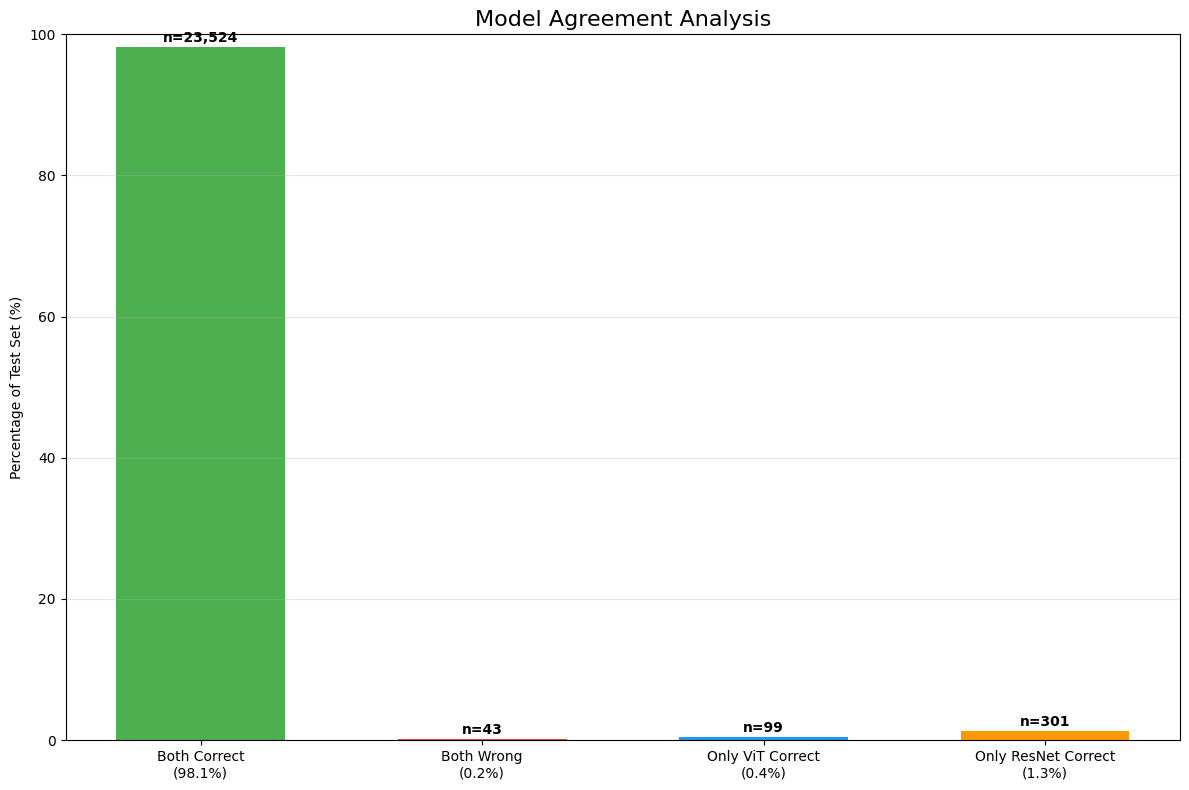

In [54]:
plt.figure(figsize=(12, 8))

categories = ['Both Correct', 'Both Wrong', 'Only ViT Correct', 'Only ResNet Correct']
values = [both_correct, both_wrong, vit_correct_only, resnet_correct_only]
colors = ['#4CAF50', '#F44336', '#2196F3', '#FF9800']

total = sum(values)
percentages = [v/total*100 for v in values]

x_labels = [f"{cat}\n({p:.1f}%)" for cat, p in zip(categories, percentages)]

bars = plt.bar(x_labels, percentages, color=colors, width=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'n={int(height*total/100):,}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 100)
plt.ylabel('Percentage of Test Set (%)')
plt.yticks([0, 20, 40, 60, 80, 100])
plt.grid(axis='y', alpha=0.3)

plt.title('Model Agreement Analysis', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'model_agreement_bars.png'), dpi=300)
plt.show()

In [55]:
comparison_results['ensemble_prob'] = (comparison_results['vit_prob'] + comparison_results['resnet_prob']) / 2
comparison_results['ensemble_pred'] = (comparison_results['ensemble_prob'] >= 0.5).astype(int)
ensemble_correct = (comparison_results['ensemble_pred'] == comparison_results['true_label']).sum()
ensemble_accuracy = ensemble_correct / total_examples

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

ensemble_metrics = {
    'accuracy': accuracy_score(comparison_results['true_label'], comparison_results['ensemble_pred']),
    'precision': precision_score(comparison_results['true_label'], comparison_results['ensemble_pred']),
    'recall': recall_score(comparison_results['true_label'], comparison_results['ensemble_pred']),
    'f1': f1_score(comparison_results['true_label'], comparison_results['ensemble_pred']),
    'auc': roc_auc_score(comparison_results['true_label'], comparison_results['ensemble_prob'])
}

print("\nEnsemble Model Performance:")
print(f"Accuracy: {ensemble_metrics['accuracy']:.4f}")
print(f"Precision: {ensemble_metrics['precision']:.4f}")
print(f"Recall: {ensemble_metrics['recall']:.4f}")
print(f"F1 Score: {ensemble_metrics['f1']:.4f}")
print(f"AUC: {ensemble_metrics['auc']:.4f}")

ensemble_comparison = pd.DataFrame({
    'Metric': metrics_to_compare[:5],
    'ViT': [vit_metrics[metric] for metric in metrics_to_compare[:5]],
    'ResNet': [resnet_metrics[metric] for metric in metrics_to_compare[:5]],
    'Ensemble': [ensemble_metrics[metric] for metric in metrics_to_compare[:5]]
})

print("\nModel Performance Comparison with Ensemble:")
print(ensemble_comparison.to_string(index=False))

ensemble_comparison.to_csv(os.path.join(results_dir, 'ensemble_comparison.csv'), index=False)


Ensemble Model Performance:
Accuracy: 0.9951
Precision: 0.9946
Recall: 0.9957
F1 Score: 0.9951
AUC: 0.9998

Model Performance Comparison with Ensemble:
   Metric      ViT   ResNet  Ensemble
 accuracy 0.985689 0.993992  0.995118
precision 0.981866 0.993661  0.994581
   recall 0.989651 0.994325  0.995660
       f1 0.985743 0.993993  0.995120
      auc 0.999034 0.999716  0.999820


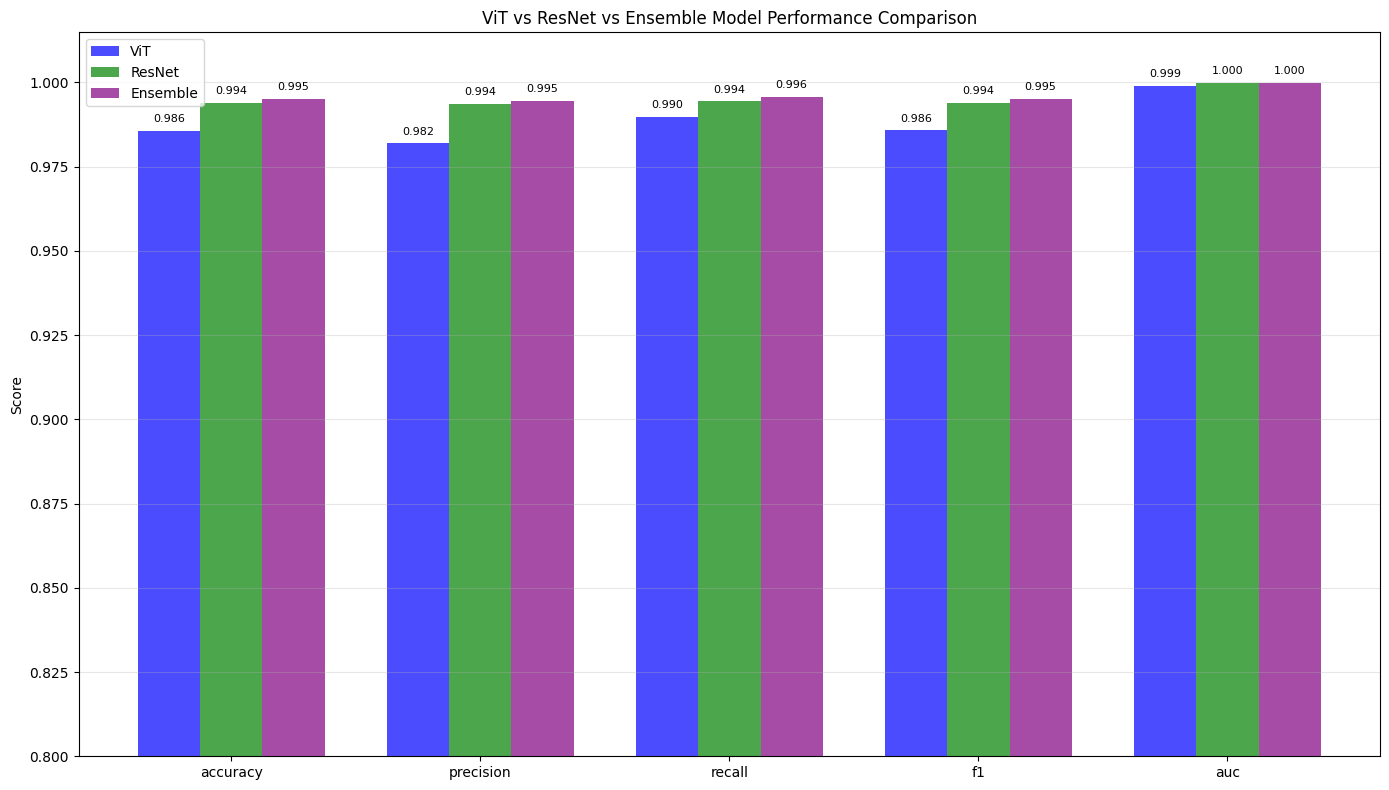

In [56]:
plt.figure(figsize=(14, 8))
x = np.arange(len(metrics_to_compare[:5]))
width = 0.25

vit_values = [vit_metrics[metric] for metric in metrics_to_compare[:5]]
resnet_values = [resnet_metrics[metric] for metric in metrics_to_compare[:5]]
ensemble_values = [ensemble_metrics[metric] for metric in metrics_to_compare[:5]]
max_value = max(max(vit_values), max(resnet_values), max(ensemble_values))

plt.bar(x - width, vit_values, width, label='ViT', color='blue', alpha=0.7)
plt.bar(x, resnet_values, width, label='ResNet', color='green', alpha=0.7)
plt.bar(x + width, ensemble_values, width, label='Ensemble', color='purple', alpha=0.7)

plt.ylabel('Score')
plt.title('ViT vs ResNet vs Ensemble Model Performance Comparison')
plt.xticks(x, metrics_to_compare[:5])

plt.ylim(0.8, max_value + 0.015)

plt.legend()
plt.grid(axis='y', alpha=0.3)

for i, metric in enumerate(metrics_to_compare[:5]):
    vit_value = vit_values[i]
    resnet_value = resnet_values[i]
    ensemble_value = ensemble_values[i]
    
    plt.text(i - width, vit_value + 0.002, f"{vit_value:.3f}", ha='center', va='bottom', fontsize=8)
    plt.text(i, resnet_value + 0.002, f"{resnet_value:.3f}", ha='center', va='bottom', fontsize=8)
    plt.text(i + width, ensemble_value + 0.002, f"{ensemble_value:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'all_models_comparison.png'), dpi=300)
plt.show()

In [57]:
# Create an Ensemble Model class
class AIvsHumanEnsemble(nn.Module):
    def __init__(self, vit_model, resnet_model):
        super(AIvsHumanEnsemble, self).__init__()
        self.vit_model = vit_model
        self.resnet_model = resnet_model
        
    def forward(self, x):
        # Get outputs from both models
        vit_output = self.vit_model(x)
        resnet_output = self.resnet_model(x)
        
        # Average the raw outputs (before sigmoid)
        ensemble_output = (vit_output + resnet_output) / 2.0
        
        return ensemble_output

# Create and save the ensemble model
print("Creating ensemble model...")
ensemble_model = AIvsHumanEnsemble(vit_model, resnet_model)
ensemble_model = ensemble_model.to(device)
ensemble_model.eval()

# Test the ensemble model on a few examples to verify it works
test_batch = next(iter(test_loader))
test_images, test_labels = test_batch
test_images = test_images.to(device)
test_labels = test_labels.to(device)

with torch.no_grad():
    ensemble_outputs = ensemble_model(test_images)
    ensemble_probs = torch.sigmoid(ensemble_outputs)
    ensemble_preds = (ensemble_probs >= 0.5).float()
    
    # Calculate accuracy on this batch
    correct = (ensemble_preds.view(-1) == test_labels.float()).sum().item()
    accuracy = correct / len(test_labels)
    
    print(f"Ensemble model batch accuracy: {accuracy:.4f}")

# Save the model weights
ensemble_save_path = os.path.join(results_dir, 'ai_vs_human_ensemble_model.pth')
torch.save(ensemble_model.state_dict(), ensemble_save_path)
print(f"Ensemble model saved to: {ensemble_save_path}")

# Save individual models if not already saved
vit_save_path = os.path.join(results_dir, 'ai_vs_human_vit_model.pth')
if not os.path.exists(vit_save_path):
    torch.save(vit_model.state_dict(), vit_save_path)
    print(f"ViT model saved to: {vit_save_path}")

resnet_save_path = os.path.join(results_dir, 'ai_vs_human_resnet_model.pth')
if not os.path.exists(resnet_save_path):
    torch.save(resnet_model.state_dict(), resnet_save_path)
    print(f"ResNet model saved to: {resnet_save_path}")

print("\nEnsemble model creation and saving complete.")

Creating ensemble model...
Ensemble model batch accuracy: 0.9688
Ensemble model saved to: evaluation_results/ai_vs_human_ensemble_model.pth
ViT model saved to: evaluation_results/ai_vs_human_vit_model.pth
ResNet model saved to: evaluation_results/ai_vs_human_resnet_model.pth

Ensemble model creation and saving complete.
